In [65]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # remove the limit for image size
import os
import numpy as np
from time import time
from matplotlib import pyplot as plt
from rgb2hed_v1 import separate_stains
import scipy
from skimage.measure import label
from skimage.morphology import remove_small_objects

In [66]:
imsrc = r'\\kukissd\Kyu_Sync\Research\Active\Aging_organized\svs\svs_back_2um'
imlist = [_ for _ in os.listdir(imsrc) if _.endswith('.tif')]
imlist

['bf19_b2_01.tif',
 'bf45_b4_01.tif',
 'bf52_b4_01.tif',
 'bf56_b4_01.tif',
 'bf57_b4_01.tif',
 'bf58_b4_01.tif',
 'bf60_b4_01.tif',
 'bf60_b4_02.tif',
 'bf60_b4_03.tif',
 'bf62_b3_01.tif',
 'bf62_b3_03.tif',
 'bf68_b3_02.tif',
 'bf68_b3_03.tif',
 'bf69_b3_01.tif',
 'bf76_b4_01.tif',
 'bm59_b4_01.tif',
 'bm60_b4_01.tif',
 'bm61_b4_01.tif',
 'bm77_b4_01.tif',
 'wf16_b2_01.tif',
 'wf20_b2_02.tif',
 'wf21_b4_01.tif',
 'wf25_b4_01.tif',
 'wf28_b4_01.tif',
 'wf29_b3_01.tif',
 'wf29_b4_01.tif',
 'wf30_b3_01.tif',
 'wf33_b3_01.tif',
 'wf35_b3_01.tif',
 'wf36_b3_01.tif',
 'wf37_b3_01.tif',
 'wf38_b3_01.tif',
 'wf38_b3_02.tif',
 'wf38_b3_03.tif',
 'wf40_b3_01.tif',
 'wf40_b3_02.tif',
 'wf41_b4_01.tif',
 'wf42_b4_01.tif',
 'wf45_b4_01.tif',
 'wf51_b4_01.tif',
 'wf54_b4_01.tif',
 'wf61_b4_01.tif',
 'wf63_b4_01.tif',
 'wf64_b3_01.tif',
 'wf64_b4_01.tif',
 'wf65_b4_01.tif',
 'wf69_b3_01.tif',
 'wf73_b3_01.tif',
 'wf74_b3_01.tif',
 'wf80_b3_01.tif',
 'wf82_b3_01.tif',
 'wf85_b3_01.tif',
 'wf86_b3_02

In [76]:
idx = 10
im = os.path.join(imsrc,imlist[idx])
im

'\\\\kukissd\\Kyu_Sync\\Research\\Active\\Aging_organized\\svs\\svs_back_2um\\bf62_b3_03.tif'

In [77]:
im_obj = Image.open(im)

In [78]:
s = time()
im_arr = np.array(im_obj)
e = time()
print('elasped time: {:.3f}'.format(e-s))
im_arr.shape

elasped time: 4.483


(6038, 20653, 3)

In [79]:
masksrc = r'\\kukissd\Kyu_Sync\Research\Active\Aging_organized\svs\svs_back_2um\classification_for_DL_skin_v6_control'
mask = os.path.join(masksrc,imlist[idx])
mask_obj = Image.open(mask)
mask_arr = np.array(mask_obj)
mask_arr.shape,im_arr.shape

((6038, 20653), (6038, 20653, 3))

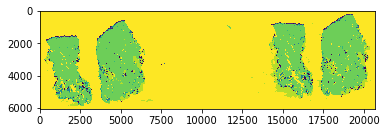

In [80]:
plt.imshow(mask_arr)

In [81]:
np.unique(mask_arr)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

1. corneum + root
2. basal + follicle
3. muscle
4. oil
5. sweat
6. nerve
7. blood
8. collagen
9. fat
10. white

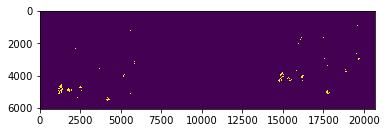

In [82]:
sweat_mask = mask_arr==5
plt.imshow(sweat_mask)

In [83]:
sweat_area = np.sum(sweat_mask)
sweat_area # N pixels classified as sweat gland

394273

In [84]:
# im_arr[sweat_mask==False]=0
# plt.imshow(im_arr)

In [85]:
s = time()
region = im_arr
rgb_from_hed = np.array([[0.650, 0.704, 0.286],
                                 [0.072, 0.990, 0.105],
                                 [0.0, 0.0, 0.0]])
rgb_from_hed[2, :] = np.cross(rgb_from_hed[0, :], rgb_from_hed[1, :])
hed_from_rgb = scipy.linalg.inv(rgb_from_hed)
Hema = separate_stains(region, hed_from_rgb)[:, :, 0]
e = time()
print('elasped time: {:.3f}'.format(e-s))

elasped time: 6.091


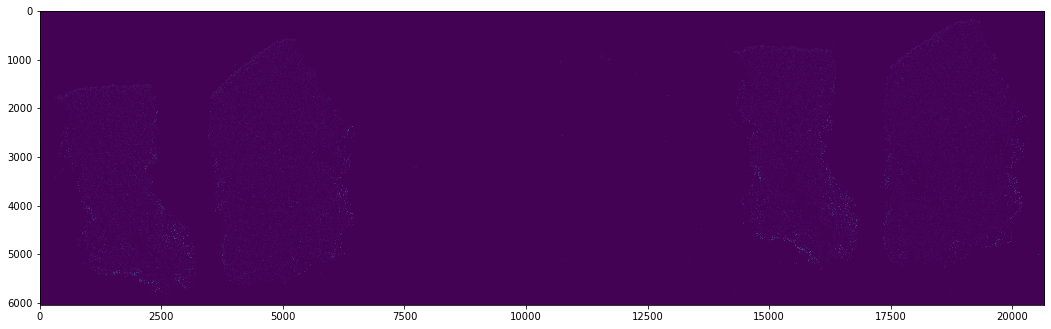

In [86]:
fig, ax = plt.subplots(figsize=(18,10))
ax.imshow(Hema)

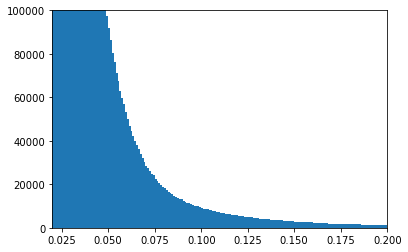

In [87]:
plt.hist(Hema.ravel(),1000,[0,1])
plt.ylim([0,100000])
plt.xlim([0.02,0.2])
plt.show()

In [95]:
threshold = 0.3
Hema[Hema < threshold] = 0
Hema[Hema > threshold] = 1
labeled_bw = label(Hema)
len(np.unique(labeled_bw))

621

In [96]:
remove_small_objects(labeled_bw, min_size=2, connectivity=1, in_place=True)
len(np.unique(labeled_bw))

118

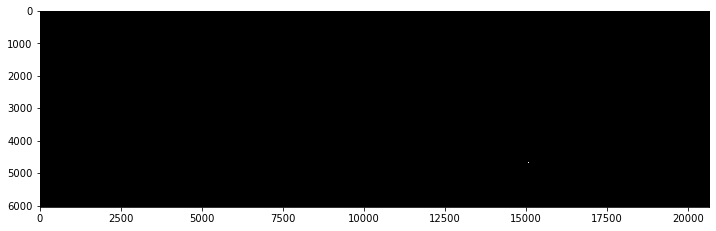

In [90]:
bw = (labeled_bw > 1) * 255
plt.figure(figsize=(12, 12))
plt.imshow(bw, cmap='gray')

In [97]:
labeled_bw[~sweat_mask] = 0
len(np.unique(labeled_bw))

1

In [ ]:
props = regionprops(labeled_bw)

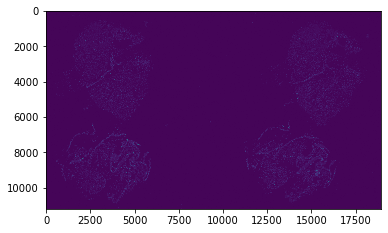

In [62]:
plt.imshow(Hema)

In [64]:
from tifffile import imsave
imsave('result.tif',Hema)
# Image.fromarray(Hema).convert("L").save('hema.png')